In [105]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/Ditruyen/Ditruyen"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Ditruyen/Ditruyen


In [106]:
import random
import numpy as np
from model.training import training

In [ ]:

class Population:
    def __init__(self, num_individual, num_phase, num_conv, num_epochs, pop_checkpoint=None, fitness_checkpoint=None):
        self.num_epochs = num_epochs
        self.num_phase = num_phase
        self.num_conv = num_conv
        self.num_individual = num_individual
        self.children = []
        self.children_fitness = []
        self.individuals = None
        self.fitness = None
        if pop_checkpoint==None:
            self.individuals = [self._create_ind() for _ in range(num_individual)]
            self.fitness = self._calculate_fitness('pop')
        else: 
            self.load_checkpoint(pop_checkpoint, fitness_checkpoint)



    def load_checkpoint(self, pop_path, fit_path):
        file = np.load(pop_path)
        self.individuals = file
        fitness = np.load(fit_path)
        self.fitness = fitness

    def save_checkpoint(self, pop_path, fit_path):
        np.save(pop_path, self.individuals)
        np.save(fit_path, self.fitness)

    def set_epoch(self, n_epochs):
        self.num_epochs = n_epochs
    
    def write_log(self):
        with open("ind_log.txt", "a") as f:
            f.write(str(self.individuals))
            f.write("\n")
        f.close()
        with open("fitness_log.txt", "a") as f1:
            f1.write(str(self.fitness))
            f1.write("\n")
        f1.close()

    def _create_ind(self):
        string_len = sum([i for i in range(self.num_conv)])
        res = np.random.randint(2, size=string_len * self.num_phase)

        for i in range(0, len(res), string_len):
            if res[i] == 0:
                res[i] = 1
        one_index = [0, 2, 5, 9]
        for phase in range(self.num_phase):
            for i in np.array(one_index) + phase * string_len:
                res[i] = 1
        return res

    def _calculate_fitness(self, pop_code):
        if pop_code == "pop":
            fitness = [training(bits_string=s, epochs=self.num_epochs) for s in self.individuals]
        else:
            fitness = [training(bits_string=s, epochs=self.num_epochs) for s in self.children]

        return fitness

    def crossover(self, r):
        def uniform_crossover(parent1, parent2):
            child1 = parent1.copy()
            child2 = parent2.copy()
            for i in range(len(parent1)):
                if random.random() < r:
                    t = child1[i]
                    child1[i] = child2[i]
                    child2[i] = t
            return child1, child2

        indices = [i for i in range(len(self.individuals))]
        np.random.shuffle(indices)
        for i in range(0, len(indices), 2):
            parent1 = self.individuals[indices[i]]
            parent2 = self.individuals[indices[i + 1]]
            child1, child2 = uniform_crossover(parent1, parent2)
            self.children.append(child1)
            self.children.append(child2)
        self.children_fitness = self._calculate_fitness("children")
        return self

    def select(self):
        def tournament_select(idx1, idx2, fitness):
            if fitness[idx1] > fitness[idx2]:
                return idx1
            else:
                return idx2

        pool = np.concatenate([self.individuals, self.children])
        pool_fitness = np.concatenate([self.fitness, self.children_fitness])
        survivor_idx = []

        indices = [i for i in range(len(pool))]
        np.random.shuffle(indices)
        for i in range(0, len(indices), 2):
            survivor_idx.append(tournament_select(indices[i], indices[i+1], pool_fitness))

        self.individuals = pool[survivor_idx]
        self.fitness = pool_fitness[survivor_idx]
        self.children_fitness = []
        self.children = []
        return


    def mutate(self, m_r):
        mutated_idx = []
        for i in range(len(self.children)):
            for j in range(len(self.children[0])):
                if random.random() < m_r:
                    mutated_idx.append(i)
                    if self.children[i][j]==0:
                        self.children[i][j]=1
                    else:
                        self.children[i][j] = 0
            if len(mutated_idx)!=0:
                if i==mutated_idx[-1]:
                    string_len = sum([i for i in range(self.num_conv)])
                    one_index = [0, 2, 5, 9]
                    for phase in range(self.num_phase):
                        for o in np.array(one_index) + phase * string_len:
                            self.children[i][o] = 1
                    self.children_fitness[i] = training(bits_string=self.children[i], epochs=self.num_epochs)
        return


In [ ]:
# pop = Population(8, 2, 5, 1)

pop = Population(8, 2, 5, 7, "./pop_checkpoint.npy", "./fit_checkpoint.npy")
print(pop.individuals)

num_generation = 10
for g in range(7,num_generation):

    pop.set_epoch(g)
    pop.save_checkpoint("./pop_checkpoint", "./fit_checkpoint")
    pop.write_log()
    print("gen ", g, pop.fitness)

    pop.crossover(0.5)
    pop.mutate(0.001)
    pop.select()



[[1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1]
 [1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1]
 [1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1]
 [1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1]
 [1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1]]
gen  7 [53.69 59.62 60.47 59.03 57.35 58.   57.01 56.6 ]
Finished Training
Accuracy of the network on the 10000 test images: 60 %
Finished Training
Accuracy of the network on the 10000 test images: 64 %
Finished Training
Accuracy of the network on the 10000 test images: 62 %
Finished Training
Accuracy of the network on the 10000 test images: 58 %
Finished Training
Accuracy of the network on the 10000 test images: 62 %
Finished Training
Accuracy of the network on the 10000 test images: 61 %
Finished Training
Accuracy of the network on the 10000 test images: 62 %
Finished Training
Accuracy of the network on the 10000 test images: 61 %
gen  8 [61.19 

In [ ]:
pop.individuals

array([[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]])

In [141]:
import re
import matplotlib.pyplot as plt

In [142]:
with open("/content/drive/MyDrive/Ditruyen/Ditruyen/fitness_log.txt", 'r') as f:
    text = f.read()
f.close()

In [143]:
m = re.findall(r'\[(.*?)(?:])', text)
a = [x.split(", ") for x in m]
a0 = a[0]
a = [x[0].split() for x in a[1:]]
X = np.insert(a, 0, a0, axis=0)
fitness = []
for x in X:
    fitness.append([float(i) for i in x])

In [144]:
avg_fitness = [np.mean(x) for x in fitness]
best_fitness = [np.max(x) for x in fitness]

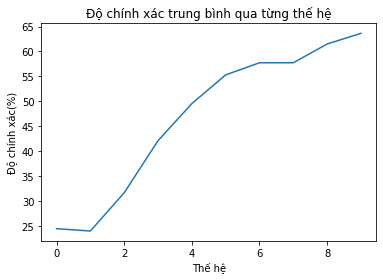

In [145]:
plt.plot(list(range(10)), avg_fitness)
plt.title("Độ chính xác trung bình qua từng thế hệ")
plt.xlabel("Thế hệ")
plt.ylabel("Độ chính xác(%)")
plt.show()

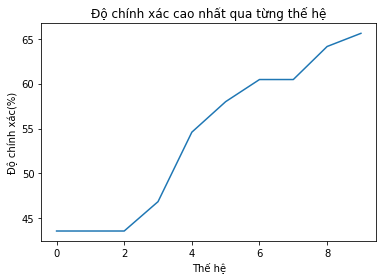

In [146]:
plt.plot(best_fitness)
plt.title("Độ chính xác cao nhất qua từng thế hệ")
plt.xlabel("Thế hệ")
plt.ylabel("Độ chính xác(%)")
plt.show()